Importing different packages

In [59]:
import numpy as np
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

Taking the inputs from the user

In [60]:
#as the initial conditions will be scaled before they are entered by the user so the value of G is taken as 1
G=1

m1=(float)(input("Enter the mass of planet 1:"))
m2=(float)(input("Enter the mass of planet 2:"))

x_1=(float)(input("Enter x coordinate of planet 1:"))
y_1=(float)(input("Enter y coordinate of planet 1:"))
x_2=(float)(input("Enter x coordinate of planet 2:"))
y_2=(float)(input("Enter y coordinate of planet 2:"))
x1=np.array([x_1,y_1])
x2=np.array([x_2,y_2])

v1xx=(float)(input("Enter the x velocity vector of planet 1:"))
v1yy=(float)(input("Enter the y velocity vector of planet 1:"))
v2xx=(float)(input("Enter the x velocity vector of planet 2:"))
v2yy=(float)(input("Enter the y velocity vector of planet 2:"))
v1=np.array([v1xx,v1yy])
v2=np.array([v2xx,v2yy])

t=(float)(input("Enter the time of prediction of position:"))

print(G)
print(m1)
print(m2)
print(x1)
print(x2)
print(v1)
print(v2)
print(t)


1
1.0
1.0
[0.  0.5]
[ 0.  -0.5]
[0.707 0.   ]
[-0.707  0.   ]
8.0


In this part based on the initial conditions I determined the positions of the two planets at different time stamps. Then I converted the array to tensor and added some noise to train the model.

In [61]:
initial_state=np.concatenate((x1,v1,x2,v2))
def planet_data(t,initial):
    x_1,y_1,v1x,v1y,x_2,y_2,v2x,v2y=initial
    rel=np.array([x_2-x_1,y_2-y_1])
    r=np.linalg.norm(rel)
    if r==0:
        print("The position of both the planets are the same")
        return 
    F=G/r**3
    a1=F*rel*m2
    a2=-F*rel*m1
    return [v1x,v1y,a1[0],a1[1],v2x,v2y,a2[0],a2[1]]

time_span=(0,t*2)
time_data=np.linspace(*time_span,1000)
#finds the solution to the second order differential equation
sol=solve_ivp(planet_data,time_span,initial_state,t_eval=time_data)
planet1_x,planet1_y=sol.y[0],sol.y[1]
planet2_x,planet2_y=sol.y[4],sol.y[5]
planet1_vx,planet1_vy=sol.y[2],sol.y[3]
planet2_vx,planet2_vy=sol.y[6],sol.y[7]

states=sol.y.T
derivatives=np.array([planet_data(t,y) for t,y in zip(time_data,states)])
a1=derivatives[:,2:4]
a2=derivatives[:,6:8]

#taking the noise level as input to add noise to the true data
noise_level=(float)(input("enter the noise level:"))
print(noise_level)

#data here refers to the positions of the two planets, which includes the x and y component of planet 1 and the x and y component of planet 2
#converting the true data from nd arrays to tensors
planet1_x_true=torch.tensor(planet1_x,dtype=torch.float32).view(-1,1)
planet1_y_true=torch.tensor(planet1_y,dtype=torch.float32).view(-1,1)
planet2_x_true=torch.tensor(planet2_x,dtype=torch.float32).view(-1,1)
planet2_y_true=torch.tensor(planet2_y,dtype=torch.float32).view(-1,1)
planet_pos_true=torch.cat([planet1_x_true,planet1_y_true,planet2_x_true,planet2_y_true],dim=1)
print(planet_pos_true.shape)

#this is the data after noise has been added to it
noise=torch.tensor(noise_level*np.random.randn(1000),dtype=torch.float32).view(-1,1)
planet1_x_train=planet1_x_true+noise
planet1_y_train=planet1_y_true+noise
planet2_x_train=planet2_x_true+noise
planet2_y_train=planet2_y_true+noise
planet_pos_noise=torch.cat([planet1_x_train,planet1_y_train,planet2_x_train,planet2_y_train],dim=1)

time_tensor=torch.tensor(time_data,dtype=torch.float32).view(-1,1)

#this is the velocity components of the two planets 
planet1_vx_tensor=torch.tensor(planet1_vx,dtype=torch.float32).view(-1,1)
planet1_vy_tensor=torch.tensor(planet1_vy,dtype=torch.float32).view(-1,1)
planet2_vx_tensor=torch.tensor(planet2_vx,dtype=torch.float32).view(-1,1)
planet2_vy_tensor=torch.tensor(planet2_vy,dtype=torch.float32).view(-1,1)
planet_v=torch.cat([planet1_vx_tensor,planet1_vy_tensor,planet2_vx_tensor,planet2_vy_tensor],dim=1)

#this is the acceleration of the two planets
planet1_a_tensor=torch.tensor(a1,dtype=torch.float32).view(-1,2)
planet2_a_tensor=torch.tensor(a2,dtype=torch.float32).view(-1,2)
planet_acc=torch.cat([planet1_a_tensor,planet2_a_tensor],dim=1)


0.7
torch.Size([1000, 4])


Based on 1000 time stamps I decided to split the dataset into 8:1 ratio. Then I seperated the ground truth values and the dataset in which noise is added.

In [62]:
#splitting the training and testing data
train_ratio=0.8
num_samples=time_tensor.shape[0] 
num_train=int(train_ratio*num_samples)
indices=np.random.permutation(num_samples)
train_idx=indices[:num_train]
test_idx=indices[num_train:]

time_train=time_tensor[train_idx]
time_test=time_tensor[test_idx]

planet_pos_train=planet_pos_noise[train_idx]
planet_pos_traintrue=planet_pos_true[train_idx]

planet_pos_test=planet_pos_noise[test_idx]
planet_pos_testtrue=planet_pos_true[test_idx]

planet_vtrain=planet_v[train_idx]
planet_vtest=planet_v[test_idx]

planet_acctrain=planet_acc[train_idx]
planet_acctest=planet_acc[test_idx]

In [63]:
#to determine the velocity and acceleration of the planets based on the noised data
def derivative(y,x):
    first_ode=[]
    for i in range(4):
        grad=torch.autograd.grad(y[:,i],x,grad_outputs=torch.ones_like(y[:,i]),create_graph=True,retain_graph=True)[0]
        first_ode.append(grad)
    return torch.cat(first_ode,dim=1)

def double_derivative(y,x):
    second_ode=[]
    for i in range(4):
        grad=torch.autograd.grad(y[:,i],x,grad_outputs=torch.ones_like(y[:,i]),create_graph=True,retain_graph=True)[0]
        second_ode.append(grad)
    return torch.cat(second_ode,dim=1)


In [64]:
#functions to include the loss between the predicted and true values then training the model accordingly
def loss(ypred,ytrue):
    return torch.mean((ypred-ytrue)**2)

def physics_loss_train(model,t):
    t.requires_grad_(True)
    planet_pos_pred=model(t)
    first_ode=derivative(planet_pos_pred,t)
    second_ode=double_derivative(first_ode,t)
    acc_loss=loss(second_ode,planet_acctrain)
    total_phyloss=acc_loss
    return total_phyloss

def data_loss_train(model,t):
    planet_pos_pred=model(t)
    return loss(planet_pos_pred,planet_pos_train)

I have used one hidden layer only, using more than that was taking a lot of time to train the model.

In [65]:
#defining the structure of the neural network
class PINN_planet(nn.Module):
    def __init__(self):
        super(PINN_planet,self).__init__()
        self.planet1_x_net=nn.Sequential(nn.Linear(1,128),nn.Tanh(),nn.Linear(128,1))
        self.planet1_y_net=nn.Sequential(nn.Linear(1,128),nn.Tanh(),nn.Linear(128,1))
        self.planet2_x_net=nn.Sequential(nn.Linear(1,128),nn.Tanh(),nn.Linear(128,1))
        self.planet2_y_net=nn.Sequential(nn.Linear(1,128),nn.Tanh(),nn.Linear(128,1))

    def forward(self,t):
        planet1_x=self.planet1_x_net(t)
        planet1_y=self.planet1_y_net(t)
        planet2_x=self.planet2_x_net(t)
        planet2_y=self.planet2_y_net(t)
        return torch.cat([planet1_x,planet1_y,planet2_x,planet2_y],dim=1)
    
model=PINN_planet()


I decided to use a decaying learning rate so that initially the model finds points close to the minima and then slowly reaches towards it. A constant learning rate was overshooting the minima.

In [67]:
#training the model
optimizer=torch.optim.Adam(model.parameters(),lr=0.09)
scheduler =torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.999)
#lambda_phy is taken as 10 higher compared to lambda_data so that the model predicts the position of the two planets strictly following laws of physics
lambda_phy=10
lambda_data=1
num_epochs=10000
#this is written to keep track the model's progress during training 
print_every=500

model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    phyloss=physics_loss_train(model,time_train)
    dataloss=data_loss_train(model,time_train)
    total_loss=lambda_phy*phyloss+lambda_data*dataloss
    total_loss.backward()
    optimizer.step()
    scheduler.step()

    if ((epoch+1)%print_every)==0:
        print(f"Epoch {epoch+1}/{num_epochs}",f"Total Loss={total_loss.item():.6f}",f"Physics Loss={phyloss.item():.6f}",
            f"Data Loss={dataloss.item():.6f}")



Epoch 500/10000 Total Loss=1.393260 Physics Loss=0.084712 Data Loss=0.546144
Epoch 1000/10000 Total Loss=0.572063 Physics Loss=0.010034 Data Loss=0.471726
Epoch 1500/10000 Total Loss=0.488438 Physics Loss=0.002794 Data Loss=0.460493
Epoch 2000/10000 Total Loss=0.478299 Physics Loss=0.001813 Data Loss=0.460171
Epoch 2500/10000 Total Loss=0.468609 Physics Loss=0.000868 Data Loss=0.459926
Epoch 3000/10000 Total Loss=0.467248 Physics Loss=0.000736 Data Loss=0.459888
Epoch 3500/10000 Total Loss=0.466425 Physics Loss=0.000657 Data Loss=0.459853
Epoch 4000/10000 Total Loss=0.465831 Physics Loss=0.000600 Data Loss=0.459827
Epoch 4500/10000 Total Loss=0.465402 Physics Loss=0.000559 Data Loss=0.459808
Epoch 5000/10000 Total Loss=0.465092 Physics Loss=0.000530 Data Loss=0.459796
Epoch 5500/10000 Total Loss=0.464870 Physics Loss=0.000508 Data Loss=0.459787
Epoch 6000/10000 Total Loss=0.464711 Physics Loss=0.000493 Data Loss=0.459781
Epoch 6500/10000 Total Loss=0.464596 Physics Loss=0.000482 Data L

I was not satisfied with the final trajectory plots so I decided to use L-BFGS optimizer in order to minimize the losses further.

In [68]:
model.train()
#L-BFGS optimizer that minimizes the losses more as it uses double derivative of the loss function to determine the minima
lbfgs_optimizer=torch.optim.LBFGS(model.parameters(),lr=1.0,max_iter=50000,max_eval=50000,
                 history_size=50,tolerance_grad=1e-8,tolerance_change=1e-9,line_search_fn="strong_wolfe")

def pinn_loss_function(model):
    phyloss=physics_loss_train(model,time_train)
    dataloss=data_loss_train(model,time_train)
    total_loss=phyloss+dataloss
    return total_loss

def closure():
    lbfgs_optimizer.zero_grad()
    loss=pinn_loss_function(model)
    loss.backward()
    return loss

print("Starting L-BFGS optimization...")
lbfgs_optimizer.step(closure)
final_loss=pinn_loss_function(model)
print(f"[L-BFGS] Final Loss={final_loss.item():.6f}")
model.eval()

Starting L-BFGS optimization...
[L-BFGS] Final Loss=0.459687


PINN_planet(
  (planet1_x_net): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (planet1_y_net): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (planet2_x_net): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (planet2_y_net): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

This is the position of the two planets as predicted by the model at a particular time as entered by the user

In [69]:
#predicting the position of the two planets 
planet_pos=model(torch.tensor([[t]],dtype=torch.float32))
#the first two columns represent the x and y components of the position vector of planet 1
#the last two columns represent the x and y components of the position vector of planet 2
print(planet_pos)


tensor([[-0.2450,  0.3878,  0.2418, -0.3893]], grad_fn=<CatBackward0>)


These are the evaluation matrices asked to calculate. The testing dataset has been used. The splitting of dataset was done in the early cells.

In [70]:
#testing the model after it has been trained 
ground_truth=planet_pos_testtrue
time_test.requires_grad_(True)
#position of the two planets predicted by the model using the testing dataset
planet_pos_pred=model(time_test)
#calculating the velocity of the two planets
first_ode=derivative(planet_pos_pred,time_test)
#calculating the acceleration of the two planets
second_ode=double_derivative(first_ode,time_test)
residuals=second_ode-planet_acctest
mean_ode_residue=torch.mean(residuals,dim=0,keepdim=True)
print(f"MEAN ODE RESIDUE: {mean_ode_residue}")

residuals=abs(ground_truth-planet_pos_pred)
mean_abs_error=torch.mean(residuals,dim=0,keepdim=True)
print(f"MEAN ABSOLUTE ERROR: {mean_abs_error}")
    

MEAN ODE RESIDUE: tensor([[ 1.4892e-03,  2.4560e-03,  5.9856e-05, -5.2358e-04]],
       grad_fn=<MeanBackward1>)
MEAN ABSOLUTE ERROR: tensor([[0.0209, 0.0205, 0.0194, 0.0201]], grad_fn=<MeanBackward1>)


This is the plot of the final trajectory. It still deviates a little and that is because of the noise added to the dataset on purpose. If we deal with real life dataset then there will always be some deviation from the data obtained just using the physics formulas on paper.

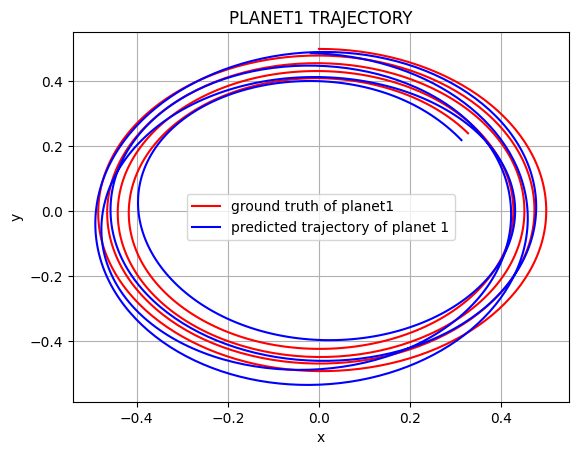

In [71]:
#converting them to tensors from arrays
pred_traj=model(time_tensor).detach().numpy()
ground_truth=planet_pos_true.detach().numpy()

plt.plot(ground_truth[:,0],ground_truth[:,1],color='red',label='ground truth of planet1')
plt.plot(pred_traj[:,0],pred_traj[:,1],'blue',label='predicted trajectory of planet 1')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title("PLANET1 TRAJECTORY")
plt.grid(True)
plt.show()

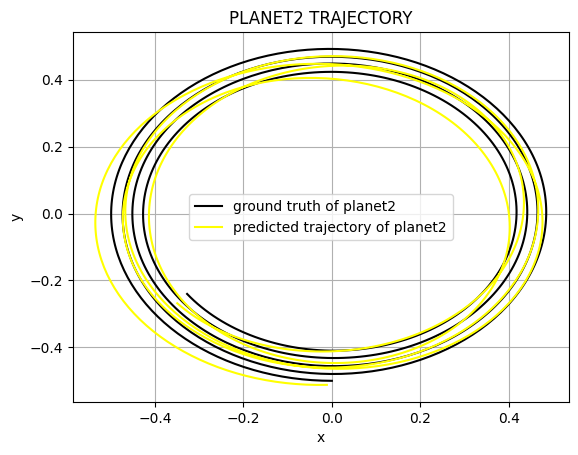

In [72]:
plt.plot(ground_truth[:,2],ground_truth[:,3],'black',label='ground truth of planet2')
plt.plot(pred_traj[:,2],pred_traj[:,3],'yellow',label='predicted trajectory of planet2')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title("PLANET2 TRAJECTORY")
plt.grid(True)
plt.show()